<a href="https://colab.research.google.com/github/saeed-mohammad-waqas/R605A-Projet-MLOps-D-tection-d-anomalies-dans-les-signaux-ECG-MIT-BIH-/blob/main/projet_ecg_R605A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wfdb scikit-learn matplotlib seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 67.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files
uploaded = files.upload()


Saving mit-bih-arrhythmia-database-1.0.0.zip to mit-bih-arrhythmia-database-1.0.0.zip


In [4]:
import zipfile
import os

# Décompression
with zipfile.ZipFile("mit-bih-arrhythmia-database-1.0.0.zip", 'r') as zip_ref:
    zip_ref.extractall("mitdb")

# Vérification du contenu
os.listdir("mitdb")


['mit-bih-arrhythmia-database-1.0.0']

In [5]:
import wfdb

# Exemple avec l’enregistrement 100
record = wfdb.rdrecord("mitdb/mit-bih-arrhythmia-database-1.0.0/100")
annotation = wfdb.rdann("mitdb/mit-bih-arrhythmia-database-1.0.0/100", 'atr')


In [7]:
import wfdb
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, find_peaks

# Chargement du signal
record_path = 'mitdb/mit-bih-arrhythmia-database-1.0.0/100'
record = wfdb.rdrecord(record_path)
annotation = wfdb.rdann(record_path, 'atr')
signal = record.p_signal[:, 0]
fs = record.fs

# Filtrage passe-bande
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=360, order=4):
    nyq = 0.5 * fs
    b, a = butter(order, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

filtered = bandpass_filter(signal, fs=fs)

# Détection des pics R
peaks, _ = find_peaks(filtered, height=0.5, distance=int(0.2 * fs))

# Extraction des segments + annotations
ann_dict = dict(zip(annotation.sample, annotation.symbol))
window = 108
features = []
labels = []

for i in range(1, len(peaks) - 1):
    r = peaks[i]
    if r - window < 0 or r + window >= len(filtered):
        continue
    segment = filtered[r - window:r + window]
    feat = {
        'amplitude_max': np.max(segment),
        'amplitude_min': np.min(segment),
        'amplitude_range': np.max(segment) - np.min(segment),
        'RR_precedent': (r - peaks[i - 1]) / fs,
        'RR_suivant': (peaks[i + 1] - r) / fs
    }
    label = ann_dict.get(r, 'N')
    features.append(feat)
    labels.append(label)

# DataFrame final
df = pd.DataFrame(features)
df['classe'] = labels
print(df.head())
print("\nRépartition des classes :")
print(df['classe'].value_counts())


   amplitude_max  amplitude_min  amplitude_range  RR_precedent  RR_suivant  \
0       1.240993      -0.197444         1.438437      0.813889    0.811111   
1       1.183630      -0.230532         1.414162      0.811111    0.791667   
2       1.105174      -0.278717         1.383891      0.791667    0.788889   
3       1.061056      -0.225754         1.286810      0.788889    0.788889   
4       1.113509      -0.217574         1.331083      0.788889    0.816667   

  classe  
0      N  
1      N  
2      N  
3      N  
4      N  

Répartition des classes :
classe
N    2243
A      28
Name: count, dtype: int64


--- Rapport de classification ---
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       657
           N       1.00      1.00      1.00       689

    accuracy                           1.00      1346
   macro avg       1.00      1.00      1.00      1346
weighted avg       1.00      1.00      1.00      1346



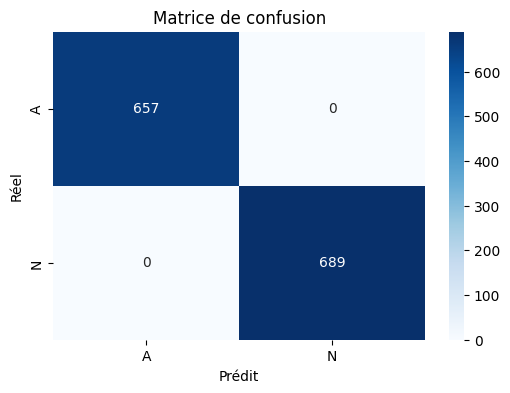

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt

# Équilibrage des classes
df_major = df[df['classe'] == 'N']
df_minor = df[df['classe'] == 'A']
df_minor_upsampled = resample(df_minor, replace=True, n_samples=len(df_major), random_state=42)
df_balanced = pd.concat([df_major, df_minor_upsampled])

# Données d'entraînement
X = df_balanced.drop(columns='classe')
y = df_balanced['classe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Évaluation
print("--- Rapport de classification ---")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
labels = clf.classes_
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()


In [9]:
df.to_csv("features.csv", index=False)
clf_filename = "modele_ecg.pkl"

import joblib
joblib.dump(clf, clf_filename)
files.download(clf_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>